In [1]:
import itertools
import math
import numpy as np 
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Gender + Race Distribution

In [ ]:
# Define joint distribution for race and gender by enumerating over all possible categories
race_gender_dist = [(("White", "Male"),0.0719653), (("White", "Female"), 0.0639007), 
        (("Asian", "Male"), 0.2067552), (("Asian", "Female"), 0.1859253),
       (("Latinx", "Male"), 0.1553989), (("Latinx", "Female"), 0.2364477),
        (("Black", "Male"), 0.0272411), (("Black", "Female"), 0.0412988),
        (("Other", "Male"), 0.0052995), (("Other", "Female"), 0.0057675)
       ]

### SES mean, SES std, GPA mean, GPA std, SAT mean, SAT std for each gender + race combo

In [ ]:
# [SES mean, SES std, GPA mean, GPA std, SAT mean, SAT std]
male_dict = {"White":[121427.9, 149881.4, 3.597782, .4756004  , 1514.847, 308.2123 ], 
               "Asian":[68396.69795, 155397.9983, 3.59036931, 0.4764913668, 1532.312001, 312.0333866],
               "Latinx":[51513.75859, 66423.411, 3.463995373, 0.4589770975, 1263.419985, 276.7460934],
               "Black":[64207.12, 89951.61, 3.334292 , .5313832  , 1307.001  , 293.2758],
               "Other":[83575.99106, 131111.6329, 3.522643541, 0.4778889762, 1612.249259, 317.8640907]}
female_dict = {"White":[104250.5, 134816, 3.708312  , .4394197   , 1442.802, 307.146],
               "Asian":[114165.0834, 143540.4448, 3.705993926, 0.4313226734, 1365.392009, 313.3273262],
               "Latinx":[44076.63903, 54385.13, 3.539571337, 0.4385647955, 1191.998155, 256.0382427],
               "Black":[53708.43, 75903.75, 3.448803  , .4934513  , 1252.245, 281.6573],
               "Other":[74665.9027, 157798.5303, 3.577260891, 0.4838154744, 1251.284592, 333.1953294]}

### Correlations to be used in Joint Distributions

In [3]:
SES_GPA_corr = .0770
SES_SAT_corr = .2073
GPA_SAT_corr = .2446

### Function to generate a multivariate normal distribution between SES, GPA, and SAT

In [4]:
def SES_GPA_SAT(SES_mean, SES_std, GPA_mean, GPA_std, SAT_mean, SAT_std, SES_GPA_corr,SES_SAT_corr, GPA_SAT_corr):
    
    means = [SES_mean, GPA_mean, SAT_mean]
    
    ## cov matrix goes SES, GPA, SAT
    cov_matrix = [[SES_std**2, SES_GPA_corr*SES_std*GPA_std, SES_SAT_corr*SES_std*SAT_std], 
                  [SES_GPA_corr*SES_std*GPA_std, GPA_std**2, GPA_SAT_corr*GPA_std*SAT_std],
                  [SES_SAT_corr*SES_std*SAT_std, GPA_SAT_corr*SAT_std*GPA_std, SAT_std**2]]
    
    
    SES, GPA, SAT = np.random.multivariate_normal(means, cov_matrix)
    
    return SES, GPA, SAT 



### Create an empty data frame to hold the data set

In [ ]:
dataEmpty = np.zeros((50000, 8), dtype=object) #Make an empty dataset - size is number of students x number of variables

## Acceptance models

### Random acceptance model 

In [ ]:
#Randomly Determine Acceptance
def random_acceptance():
    
    return np.random.choice([0,1], p = [.6,.4])

### Trained Acceptance

In [ ]:
#Determine Probability of Acceptance from a Logit model trained on 10% of the actual students data

race_coeffs = {
    "White": 0,
    "Black": .15444 ,  
    "Asian": -0.04253839051,
    "Latinx": 0.1380144983,
    "Other":  0.2014900518
}

gender_coeffs = {
    "Male": 0,
    "Female": .6882   
}


def partial_logistic_acceptance(gender, race, GPA, SAT, SES):
    
    
    const = -26.55   
    female_coeff = gender_coeffs[gender]
    race_coeff = race_coeffs[race]
    gpa_coeff = 4.539  
    SAT_coeff = .0094   
    SES_coeff = -.00036  
    
    neg_regression_eq = -(const + female_coeff + race_coeff + gpa_coeff*GPA + SAT_coeff*SAT + SES_coeff*SES)
    if neg_regression_eq > 500:
        neg_regression_eq = 500
        
    
    epsilon = 0 #Ask Dr B -- it is predicting pretty much 0 and 1 every time
    
    
    prob_acceptance = 1/(1+math.exp(neg_regression_eq))

    
    if prob_acceptance > .5:
        prob_acceptance -= epsilon
    else:
        prob_acceptance + epsilon
    
    return np.random.choice([0,1], p=[1-prob_acceptance, prob_acceptance])   

###Modeled Acceptance

In [ ]:
#Determine Probability of Acceptance from a Logit model trained on all of the actual students data

race_coeffs = {
    "White": 0,
    "Black": -.7591543 ,  
    "Asian": 0.1736083679,
    "Latinx": -0.9139760692,
    "Other": -0.1170132372
}

gender_coeffs = {
    "Male": 0,
    "Female": .0363829   
}


def complete_logistic_acceptance(gender, race, GPA, SAT, SES):
    
    
    const = -15.32876   
    female_coeff = gender_coeffs[gender]
    race_coeff = race_coeffs[race]
    gpa_coeff = 4.508206   
    SAT_coeff = .0030752   
    SES_coeff = .0116858  
    
    neg_regression_eq = -(const + female_coeff + race_coeff + gpa_coeff*GPA + SAT_coeff*SAT + SES_coeff*SES)
    if neg_regression_eq > 500:
        neg_regression_eq = 500
        
    
    epsilon = 0 #Ask Dr B -- it is predicting pretty much 0 and 1 every time
    
    
    prob_acceptance = 1/(1+math.exp(neg_regression_eq))

    
    if prob_acceptance > .5:
        prob_acceptance -= epsilon
    else:
        prob_acceptance + epsilon
    
    return np.random.choice([0,1], p=[1-prob_acceptance, prob_acceptance])    

### Generate the data set using the following function

In [ ]:
def randomizeData():
    for i in range(0, len(dataEmpty)):
        #select a gender + race 
        index = np.random.choice(len(race_gender_dist), size=1, p=[x[1] for x in race_gender_dist])[0]
        race = race_gender_dist[index][0][0]
        gender = race_gender_dist[index][0][1]
        
        #select which dictionary to use containing SES mean, SES std, GPA mean, GPA std, SAT mean, SAT std
        if gender == "Female":
            gender_dict = female_dict
        if gender == "Male":
            gender_dict = male_dict 
        dist = gender_dict[race]
        
        # Generate a covariance matrix and run the multivariate normal command to extract an SES, GPA, SAT 
        SES, GPA, SAT = SES_GPA_SAT(dist[0], dist[1], dist[2], dist[3], dist[4], dist[5], dist[6], dist[7], dist[8])
        
        #Add the student to the dataset using their SES, GPA, SAT, Gender, and Race values 
        dataEmpty[i][0], dataEmpty[i][1], dataEmpty[i][2] = round(SES), round(GPA, 2), round(SAT)
        dataEmpty[i][3] = gender
        dataEmpty[i][4] = race
        
        #Determine acceptance using each of the three acceptance models
        dataEmpty[i][5] = random_acceptance()
        dataEmpty[i][6] = partial_logistic_acceptance(gender, race, GPA, SAT, SES)
        dataEmpty[i][7] = complete_logistic_acceptance(gender, race, GPA, SAT, SES)
        
randomizeData()

In [11]:
## Check if any negative SES values were generated and perform translation to positive Reals        
min_SES_value = np.min(dataEmpty[:, 0])
if min_SES_value < 0:
    dataEmpty[:,0] =  dataEmpty[:,0] - min_SES_value


In [12]:
generatedData = pd.DataFrame(data = dataEmpty, columns=["SES", "GPA", "SAT", "Gender", "Race", "Random Acceptance", "Partial Logistic Acceptance", "Complete Logistic Acceptance"])

In [ ]:
genders = ["Female", "Male"]
races = ["White", "Asian", "Latinx", "Black", "Other"]

## The following cells generate 3D projection visuals for each pair of variables in the multivariate normal distribution

In [16]:
##Note - SES Visuals is in Thousands of Dollars

In [17]:
SES_mean, SES_std, GPA_mean, GPA_std, SAT_mean, SAT_std, SES_GPA_corr,SES_SAT_corr, GPA_SAT_corr = [86803.54/1000, 127214.5/1000, 3.58, .468, 1368, 327, SES_GPA_corr,SES_SAT_corr, GPA_SAT_corr]

In [18]:
means = [GPA_mean, SAT_mean]
    

cov_matrix = [[GPA_std**2, GPA_SAT_corr*GPA_std*SAT_std],
              [GPA_SAT_corr*SAT_std*GPA_std, SAT_std**2]]

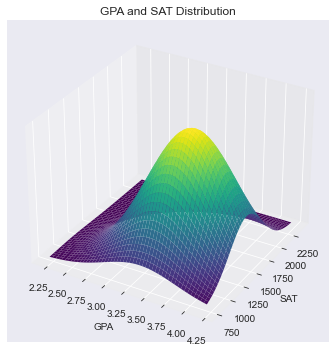

In [19]:
# Importing the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']=14,6
fig = plt.figure()

# Initializing the random seed
random_seed=1000


# mean = np.array([0,0])

# Storing density function values for
# further analysis
pdf_list = []


# Generating a Gaussian bivariate distribution
# with given mean and covariance matrix
distr = multivariate_normal(cov = cov_matrix, mean = means, seed = random_seed)

# Generating a meshgrid complacent with
# the 3-sigma boundary
mean_1, mean_2 = means[0], means[1]
sigma_1, sigma_2 = cov_matrix[0][0], cov_matrix[1][1]

x = np.linspace(2.2, 4.2, num=500)
y = np.linspace(750,2400, num=750)
X, Y = np.meshgrid(x,y)

# Generating the density function
# for each point in the meshgrid
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])

# Plotting the density function values
ax = fig.add_subplot(131, projection = '3d')
ax.plot_surface(X, Y, pdf, cmap = 'viridis')
plt.xlabel("GPA")
plt.ylabel("SAT")
plt.title("GPA and SAT Distribution")
pdf_list.append(pdf)
ax.axes.zaxis.set_ticks([])

plt.tight_layout()
plt.show()

In [21]:
means = [SES_mean, GPA_mean]
    
## cov matrix goes SES, GPA, SAT
cov_matrix =[[SES_std**2, SES_GPA_corr*SES_std*GPA_std], 
            [SES_GPA_corr*SES_std*GPA_std, GPA_std**2]]
    
    

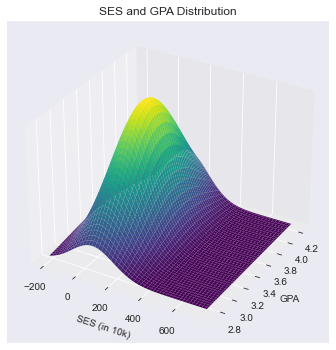

In [24]:
# Importing the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']=14,6
fig = plt.figure()

# Initializing the random seed
random_seed=1000


# mean = np.array([0,0])

# Storing density function values for
# further analysis
pdf_list = []


# Generating a Gaussian bivariate distribution
# with given mean and covariance matrix
distr = multivariate_normal(cov = cov_matrix, mean = means, seed = random_seed)

# Generating a meshgrid complacent with
# the 3-sigma boundary
mean_1, mean_2 = means[0], means[1]
sigma_1, sigma_2 = cov_matrix[0][0], cov_matrix[1][1]

x = np.linspace(-200, 750, num=100)
y = np.linspace(2.75, 4.25, num=100)
X, Y = np.meshgrid(x,y)

# Generating the density function
# for each point in the meshgrid
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])

# Plotting the density function values
ax = fig.add_subplot(131, projection = '3d')
ax.plot_surface(X, Y, pdf, cmap = 'viridis')
plt.xlabel("SES (in 10k)")
plt.ylabel("GPA")
plt.title("SES and GPA Distribution")
pdf_list.append(pdf)
ax.axes.zaxis.set_ticks([])

plt.tight_layout()
plt.show()

In [25]:
means = [SES_mean, SAT_mean]
    
## cov matrix goes SES, GPA, SAT
cov_matrix = [[SES_std**2, SES_SAT_corr*SES_std*SAT_std], 
             [SES_SAT_corr*SES_std*SAT_std, SAT_std**2]]
    

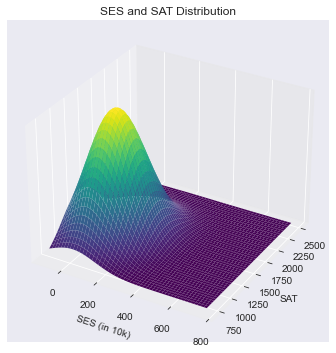

In [26]:
# Importing the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']=14,6
fig = plt.figure()

# Initializing the random seed
random_seed=1000


# mean = np.array([0,0])

# Storing density function values for
# further analysis
pdf_list = []


# Generating a Gaussian bivariate distribution
# with given mean and covariance matrix
distr = multivariate_normal(cov = cov_matrix, mean = means, seed = random_seed)

# Generating a meshgrid complacent with
# the 3-sigma boundary
mean_1, mean_2 = means[0], means[1]
sigma_1, sigma_2 = cov_matrix[0][0], cov_matrix[1][1]

x = np.linspace(-100, 759, num=1000)
y = np.linspace(700, 2500, num=1000)
X, Y = np.meshgrid(x,y)

# Generating the density function
# for each point in the meshgrid
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])

# Plotting the density function values
ax = fig.add_subplot(131, projection = '3d')
ax.plot_surface(X, Y, pdf, cmap = 'viridis')
plt.xlabel("SES (in 10k)")
plt.ylabel("SAT")
plt.title("SES and SAT Distribution")
pdf_list.append(pdf)
ax.axes.zaxis.set_ticks([])

plt.tight_layout()
plt.show()

In [ ]:
## Save the Data

In [27]:

generatedData.to_pickle('./ML Items/GeneratedData')
generatedData.to_csv('./GeneratedData.csv')